### Propuesta 
#### RNN LSTM Multivariate Time Series
....

In [253]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame, concat, read_csv
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM
from keras.models import  Sequential
from keras import backend as K
from keras import optimizers

Antes de que se pueda utilizar el aprendizaje automático para prediccion de valores, los problemas de pronóstico de series de tiempo deben reformularse como problemas de aprendizaje supervisados. Desde una secuencia hasta pares de secuencias de entrada y salida.

In [272]:
# Convertir Serie de Tiempo en Dataset Supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Secuencia Input (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Secuencia Forecast-Prediccion (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Secuencias Juntas
    agg = concat(cols, axis=1)
    agg.columns = names
    # Eliminar outlayers NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def graficaUnitaria(fix:16,fiy:8,historyXYZ,strEvaluacion):
    figure(figsize=(fix,fiy))
    if(strEvaluacion=='accuracy'):
        pyplot.title("ACCURACY vs VAL_ACCURACY")
        pyplot.plot(historyXYZ.history['acc'], label='Train ACC')
        pyplot.legend()
        pyplot.plot(historyXYZ.history['val_acc'], label='Test VAL_aCC')
        pyplot.legend()
        pyplot.show()
    else:
        pyplot.title("LOSS vs VAL_LOSS")
        pyplot.plot(historyXYZ.history['loss'], label='Train LOSS')
        pyplot.plot(historyXYZ.history['val_loss'], label='Test VAL_LOSS')
        pyplot.legend()
        pyplot.show()

#### Preparacion de Datos
Lectura, Normalizacion, Conversion a un Dataframe de Aprendizaje Supervisado

In [255]:
dataset = read_csv('aucorpTrain.csv', header=0, index_col=0)
dataset=dataset.iloc[:,2:]
values = dataset.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# Cast a un solo tipo de dato
values = values.astype('float32')
# Normalizacion
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Datos a Modelo Aprendizaje Supervisado
reframed = series_to_supervised(scaled, 1, 1)
#Datos para entrenar
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

### Caso 1
50 epochs, 1 Capa LSTM, Dense, Optimizador Adam

In [256]:
# Train and Test Data
values = reframed.values
train = values[:68, :]
test = values[69:, :]
# Separacion Datos Input-Output
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# Reshape input para tener 3D [muestra, timesteps, caracteristicas]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [257]:
# RED NEURONAL
modelC1 = Sequential()
modelC1.add(LSTM(12, dropout=0.0002, input_shape=(train_X.shape[1], train_X.shape[2])))
modelC1.add(Dense(1, activation='sigmoid'))
sgd = optimizers.SGD(lr=0.0002, decay=1e-7, momentum=0.9, nesterov=True)
modelC1.compile(loss='mae', optimizer='adam', metrics=['accuracy']) #sgd 'adam', optimizer=
historyC1 = modelC1.fit(train_X, train_y, epochs=1000, batch_size=40, validation_data=(test_X, test_y),validation_split=0.2, verbose=0, shuffle=False)
modelC1.summary()

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_175 (LSTM)              (None, 12)                1392      
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 13        
Total params: 1,405
Trainable params: 1,405
Non-trainable params: 0
_________________________________________________________________


#### Evaluacion Resultados


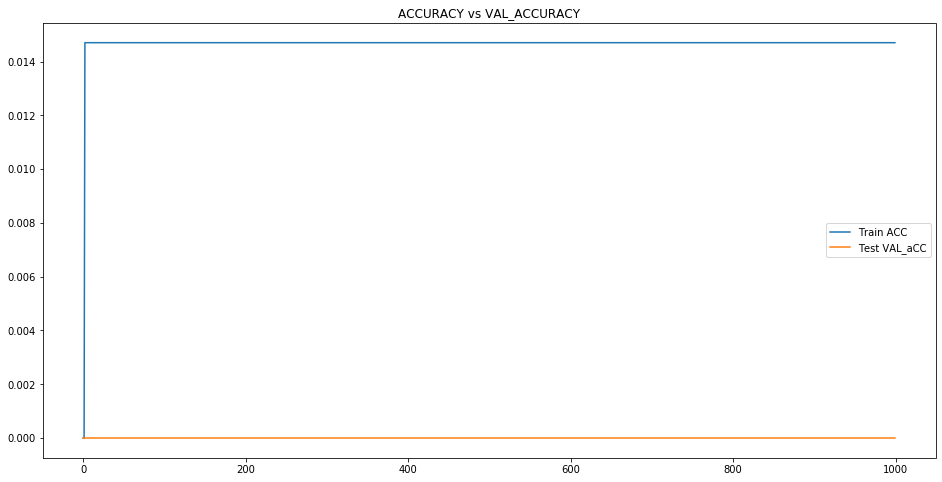

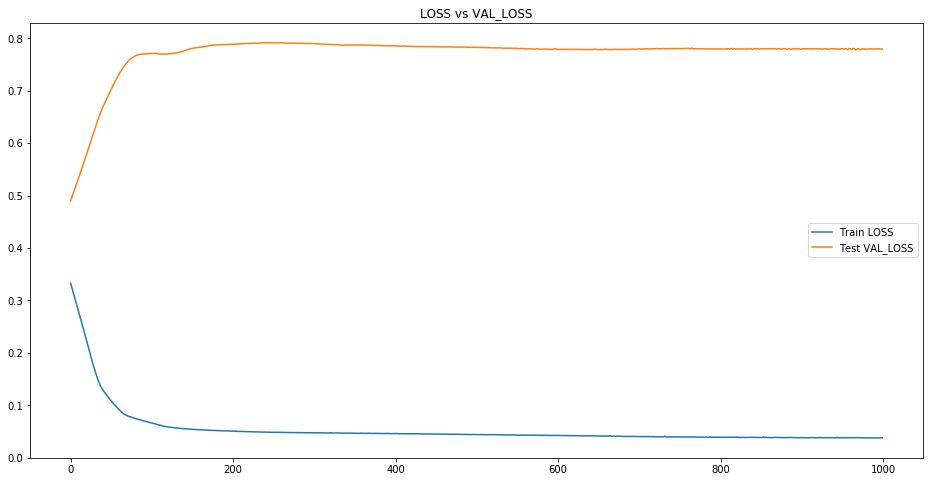

In [276]:
%pylab inline
graficaUnitaria(16,8,historyC1,'accuracy')
graficaUnitaria(16,8,historyC1,'loss')

### Caso 2
50 epochs, 3 Capa LSTM (50,50,50), Dense, Optimizador Adam

In [259]:
# RED NEURONAL
modelC2 = Sequential()
modelC2.add(LSTM(12, dropout=0.0002, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences= True))
modelC2.add(LSTM(12, dropout=0.0002, return_sequences=True))
modelC2.add(LSTM(12, dropout=0.0002))
modelC2.add(Dense(1, activation='sigmoid'))
modelC2.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])#'adam')
# Fitting
historyC2 = modelC2.fit(train_X, train_y, epochs=1000, batch_size=40, validation_data=(test_X, test_y),validation_split=0.2, verbose=0, shuffle=True)
modelC2.summary()

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_176 (LSTM)              (None, 1, 12)             1392      
_________________________________________________________________
lstm_177 (LSTM)              (None, 1, 12)             1200      
_________________________________________________________________
lstm_178 (LSTM)              (None, 12)                1200      
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 13        
Total params: 3,805
Trainable params: 3,805
Non-trainable params: 0
_________________________________________________________________


#### Evaluacion de Resultados

Populating the interactive namespace from numpy and matplotlib


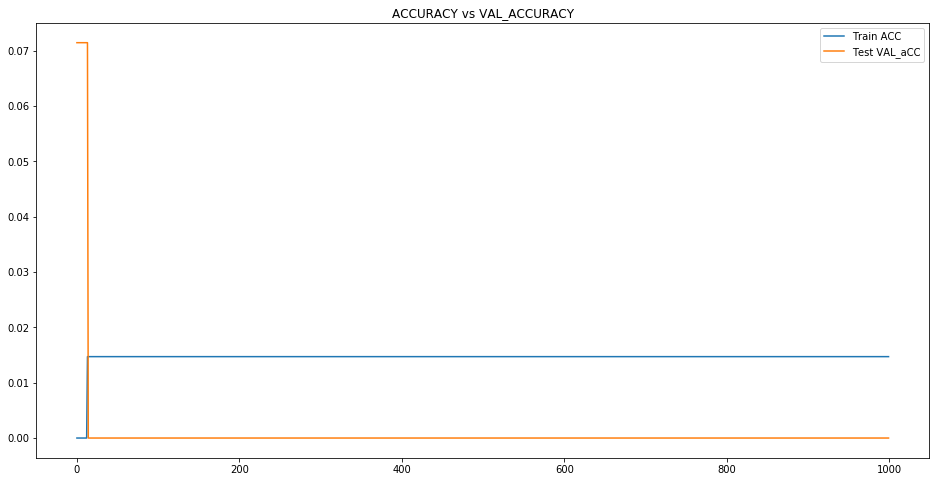

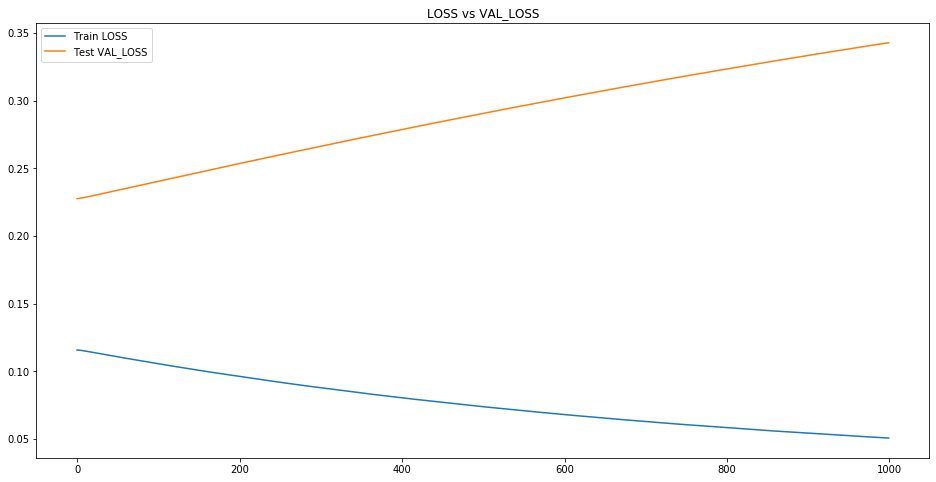

In [278]:
%pylab inline
graficaUnitaria(16,8,historyC2,'accuracy')
graficaUnitaria(16,8,historyC2,'loss')

### Caso 3
50 epochs, 4 Capa LSTM (50,40,30,20), Dense, Optimizador Adam

In [261]:
# RED NEURONAL
modelC3 = Sequential()
modelC3.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences= True))
modelC3.add(LSTM(40, return_sequences=True))
modelC3.add(LSTM(30, return_sequences=True))
modelC3.add(LSTM(20))
modelC3.add(Dense(1, activation='sigmoid'))
modelC3.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])#'adam')
# Fitting
historyC3 = modelC3.fit(train_X, train_y, epochs=1000, batch_size=40, validation_data=(test_X, test_y),validation_split=0.2, verbose=0, shuffle=False)
modelC3.summary()

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_179 (LSTM)              (None, 1, 50)             13400     
_________________________________________________________________
lstm_180 (LSTM)              (None, 1, 40)             14560     
_________________________________________________________________
lstm_181 (LSTM)              (None, 1, 30)             8520      
_________________________________________________________________
lstm_182 (LSTM)              (None, 20)                4080      
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 21        
Total params: 40,581
Trainable params: 40,581
Non-trainable params: 0
_________________________________________________________________


#### Evaluacion de Resultados

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


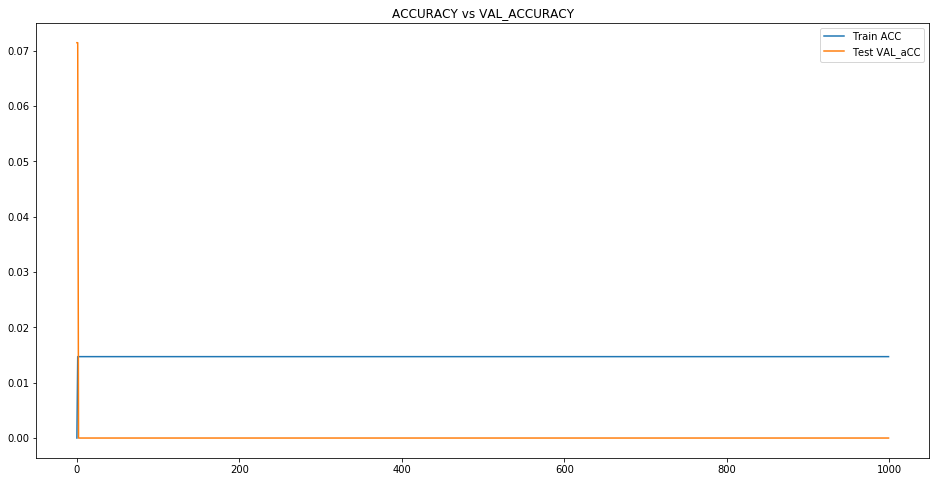

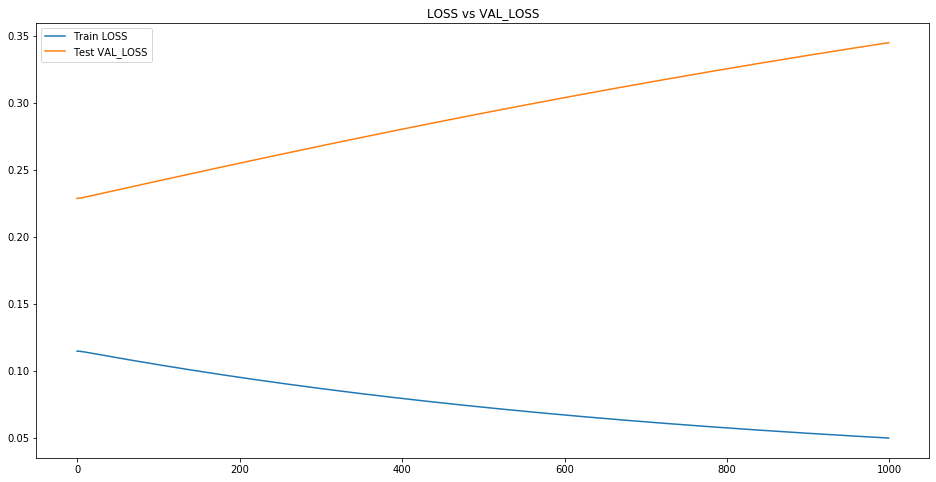

In [279]:
%pylab inline
graficaUnitaria(16,8,historyC3,'accuracy')
graficaUnitaria(16,8,historyC3,'loss')

### Caso 4
500 epochs, 3 Capa LSTM (50,40,30,20), Dense, Optimizador Adam

In [263]:
# RED NEURONAL
modelC4 = Sequential()
modelC4.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences= True))
modelC4.add(LSTM(40, return_sequences=True))
modelC4.add(LSTM(30, return_sequences=True))
modelC4.add(LSTM(20))
modelC4.add(Dense(1, activation='sigmoid'))
modelC4.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])#'adam')
# Fitting
historyC4 = modelC4.fit(train_X, train_y, epochs=1000, batch_size=40, validation_data=(test_X, test_y),validation_split=0.2, verbose=0, shuffle=True)
modelC4.summary()


Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_183 (LSTM)              (None, 1, 50)             13400     
_________________________________________________________________
lstm_184 (LSTM)              (None, 1, 40)             14560     
_________________________________________________________________
lstm_185 (LSTM)              (None, 1, 30)             8520      
_________________________________________________________________
lstm_186 (LSTM)              (None, 20)                4080      
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 21        
Total params: 40,581
Trainable params: 40,581
Non-trainable params: 0
_________________________________________________________________


In [264]:
#print(modelC4.history.history)

### Evaluacion de Resultados

Populating the interactive namespace from numpy and matplotlib


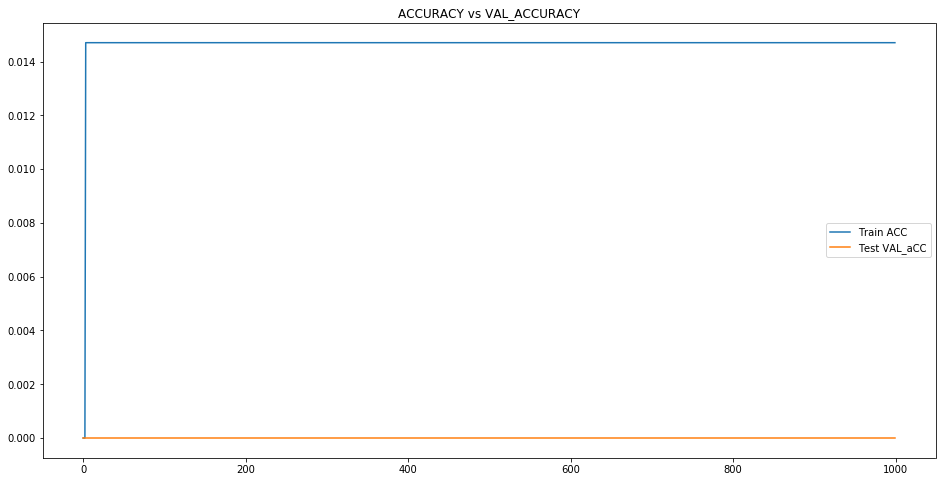

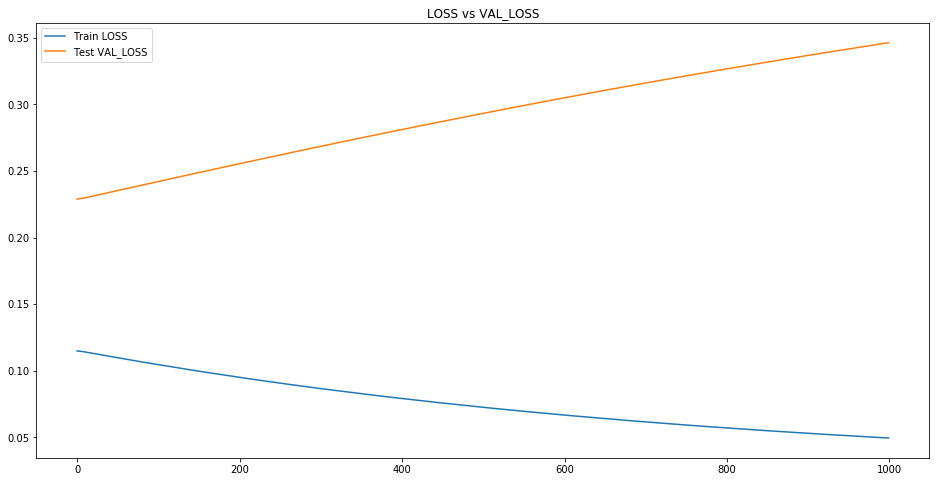

In [280]:
%pylab inline
graficaUnitaria(16,8,historyC4,'accuracy')
graficaUnitaria(16,8,historyC4,'loss')


In [266]:
modelC1
modelC2
modelC3
modelC4
historyC1
historyC2
historyC3
historyC4



In [284]:
# Prediccion
#test_X = np.reshape(test_X,(test_X.shape[0],test_X.shape[1],1))

ypredict = modelC1.predict(test_X)
#ypredict

ValueError: Error when checking input: expected lstm_175_input to have 3 dimensions, but got array with shape (14, 16)

In [282]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Inversion de Escala MinMax
inv_yhat = concatenate((ypredict, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Inversion de Escala Actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Calculo de RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (14,16) (12,) (14,16) 